현재 모델이 너무 closed에 과잉 반응하면서 open class에 민감하지 못한 건,  
-> feature 표현이 너무 부드러워져서 edge case를 못 잡는 것일 수도 있음  
BN은 훈련 데이터에선 잘 맞춰주지만, 테스트셋에선 오히려 일반화 저하될 수 있음  

In [1]:
import os, random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("GPU 사용 가능 여부:", tf.config.list_physical_devices("GPU"))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K


# Focal Loss ===========================================================
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon=K.epsilon()
        y_pred=K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true*K.log(y_pred) - (1 - y_true)*K.log(1 - y_pred)
        weight = alpha*y_true*K.pow(1 - y_pred, gamma) + \
                 (1 - alpha)*(1 - y_true)*K.pow(y_pred, gamma)
        return K.mean(weight * cross_entropy, axis=-1)
    return loss


# ImageGenerator ===========================================================
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

# 모델 정의 ===========================================================
# BatchNormalization 제거 
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss=focal_loss(gamma=2.0, alpha=0.25), metrics=["accuracy"])
# 학습
history=model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1)

2025-06-13 17:31:16.213742: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 17:31:16.253254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 17:31:16.253276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 17:31:16.255031: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 17:31:16.262195: I tensorflow/core/platform/cpu_feature_guar

GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.
Epoch 1/20


2025-06-13 17:31:21.074587: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 17:31:21.074671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 17:31:21.074704: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 17:31:21.259665: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 17:31:21.259721: I external/local_xla/xla/stream_executor

1200/1200 [==============================] - 42s 33ms/step - loss: 0.0450 - accuracy: 0.8254 - val_loss: 0.0368 - val_accuracy: 0.8782
Epoch 2/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0358 - accuracy: 0.8744 - val_loss: 0.0302 - val_accuracy: 0.9126
Epoch 3/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0327 - accuracy: 0.8909 - val_loss: 0.0361 - val_accuracy: 0.8646
Epoch 4/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0300 - accuracy: 0.8994 - val_loss: 0.0447 - val_accuracy: 0.7866
Epoch 5/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0295 - accuracy: 0.9038 - val_loss: 0.0288 - val_accuracy: 0.9193
Epoch 6/20
1200/1200 [==============================] - 26s 21ms/step - loss: 0.0281 - accuracy: 0.9096 - val_loss: 0.0389 - val_accuracy: 0.8119
Epoch 7/20
1200/1200 [==============================] - 26s 21ms/step - loss: 0.0274 - accuracy: 0.9105 - val_loss: 0.0334 - val_accura

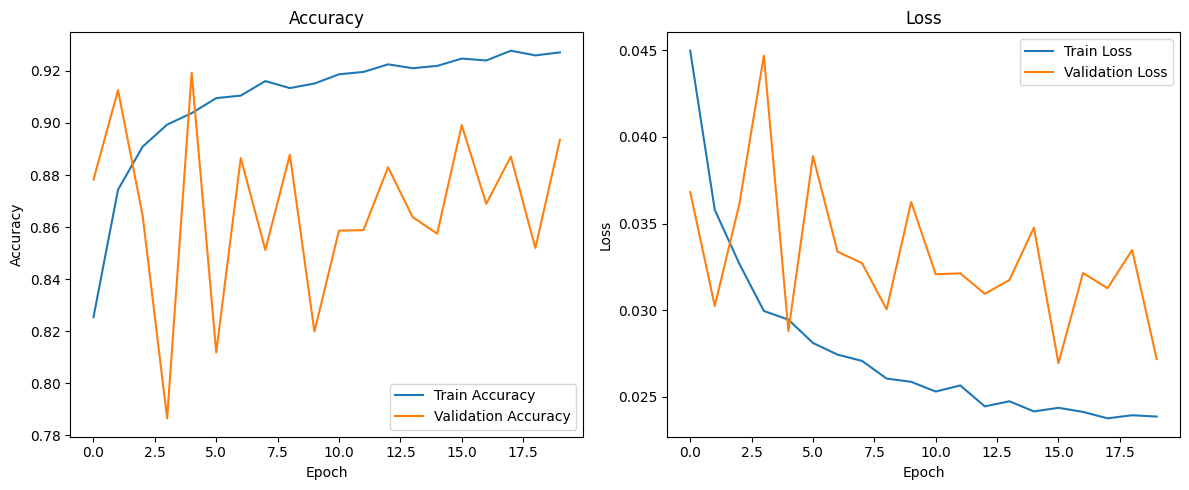

              precision    recall  f1-score   support

      closed       0.83      0.99      0.90      4800
        open       0.99      0.80      0.88      4800

    accuracy                           0.89      9600
   macro avg       0.91      0.89      0.89      9600
weighted avg       0.91      0.89      0.89      9600



2025-06-13 17:40:47.400314: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4382574361042094395


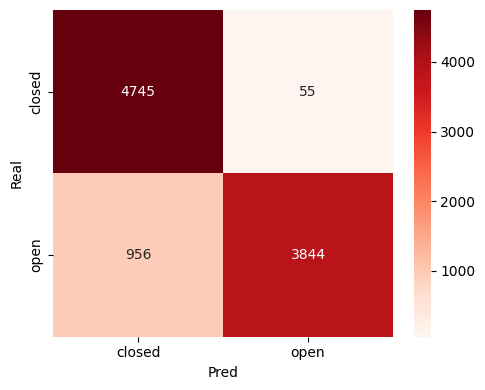

In [2]:
# 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/15_no_bn_training_plot.png")
plt.show()


y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)

with open("../../results/reports/15_no_bn_classification_report.txt", "w") as f:
    f.write(report)


conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/15_no_bn_confusion_matrix.png")
plt.show()

In [4]:
os.makedirs("../../src/models/07_reStructure_Model", exist_ok=True)
model.save("../../src/models/07_reStructure_Model/model.keras")

이전까지 가장 문제였던 open recall이 0.61 -> 0.80으로 개선 + closed recall은 여전히 유지됨 (0.99)  
이전 실험들 대비 FN(open -> closed) 수치가 많이 줄어들음  
오버피팅 줄고, 일반화 성능 확실히 향상  

BN 제거 효과: gradient 흐름이 넓어지고 표현력 향상으로 이어짐  
Dropout(0.3): 지나친 regularization 없이 overfitting 적절히 제어  

여전히 open을 closed로 잘못 예측하는 케이스(956)가 너무 많아서, 실시간 시스템에 도입하면 졸음 아닌데 계속 경고 울리는 상황이 자주 발생함  

우선은 모델 저장하고 좀 더 실험해보기  